In [125]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [126]:
item_id = 554
year_backward = 15
dataset = None
device = "cpu"

def load_data():
    df = pd.read_csv("Runescape_Item_Prices.csv")

    df = pd.read_csv("Runescape_Item_Prices.csv")
    df["date"] = pd.to_datetime(df['date'])

    # fetch last 15 years
    today = datetime.today()
    start_date = today.replace(year = today.year - 15, month = today.month - 3)

    df = df[df["date"] >= start_date]

    # filter out unwanted items / unwated info
    df = df[df["id"] == item_id]
    df = df.drop("volume", axis = 1)
    df = df.drop("Unnamed: 0", axis = 1)
    df = df.drop("id", axis = 1)
    df = df.drop("date", axis = 1)

    df.to_csv("15_year_prices_item_554")

In [127]:
load_data()

In [ ]:
df = pd.read_csv('15_year_prices_item_554')

# from this dataset, the only usable data ranging 10+ years is the price.
# We can feature engineer some moving averages into the dataset.
prices = df.values[:, 1]

std = prices.std()
mean = prices.mean()

prices = (prices - mean) / std

# train, val, test split (80, 10, 10)
train_size = int(0.70 * len(prices))
val_size = int(0.15 * len(prices))
test_size = len(prices) - train_size - val_size


df = pd.DataFrame(prices, columns = ["prices"])
df["7-day MA"] = df["prices"].rolling(window = 7).mean()
df["21-day MA"] = df["prices"].rolling(window = 21).mean()
df["7-day STD"] = df["prices"].rolling(window = 7).std()

dataset = df.values
print(len(dataset))
print(len(dataset[0]))
print(torch.Tensor(dataset).shape)

train_data = dataset[:train_size]
val_data = dataset[train_size:train_size + val_size]
test_data = dataset[train_size + val_size:]


In [ ]:
def create_sequences(dataset, seq_length, pred_length):
  X = []
  y = []
  for i in range(len(dataset) - seq_length - pred_length):
    seq = dataset[i : i + seq_length]
    target = dataset[i + seq_length : i + seq_length + pred_length]
    X.append(seq)
    y.append(target[:, 0])
  return X, y

seq_length = 90
pred_length = 5
X_train, y_train = create_sequences(train_data, seq_length, pred_length)
X_val, y_val = create_sequences(val_data, seq_length, pred_length)
X_test, y_test = create_sequences(test_data, seq_length, pred_length)

# We must remove first 21 elements since our longest
# rolling indicator is 21-day MA
X_train = X_train[21:]
y_train = y_train[21:]
X_val = X_val[21:]
y_val = y_val[21:]
X_test = X_test[21:]
y_test = y_test[21:]

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
class RunescapeDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = RunescapeDataset(X_train, y_train)
val_dataset = RunescapeDataset(X_val, y_val)
test_dataset = RunescapeDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:
# model definition multi-step preds

class LSTMPredictor(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTMPredictor, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, (h, c) = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

Epoch 1/17, Train Loss: 0.3673, Val Loss: 0.7752
Epoch 2/17, Train Loss: 0.0391, Val Loss: 0.1959
Epoch 3/17, Train Loss: 0.0276, Val Loss: 0.0911
Epoch 4/17, Train Loss: 0.0230, Val Loss: 0.0472
Epoch 5/17, Train Loss: 0.0197, Val Loss: 0.0332
Epoch 6/17, Train Loss: 0.0174, Val Loss: 0.0241
Epoch 7/17, Train Loss: 0.0161, Val Loss: 0.0529
Epoch 8/17, Train Loss: 0.0152, Val Loss: 0.0349
Epoch 9/17, Train Loss: 0.0139, Val Loss: 0.0212
Epoch 10/17, Train Loss: 0.0133, Val Loss: 0.0242
Epoch 11/17, Train Loss: 0.0121, Val Loss: 0.0161
Epoch 12/17, Train Loss: 0.0112, Val Loss: 0.0295
Epoch 13/17, Train Loss: 0.0106, Val Loss: 0.0124
Epoch 14/17, Train Loss: 0.0102, Val Loss: 0.0122
Epoch 15/17, Train Loss: 0.0095, Val Loss: 0.0207
Epoch 16/17, Train Loss: 0.0090, Val Loss: 0.0159
Epoch 17/17, Train Loss: 0.0085, Val Loss: 0.0166


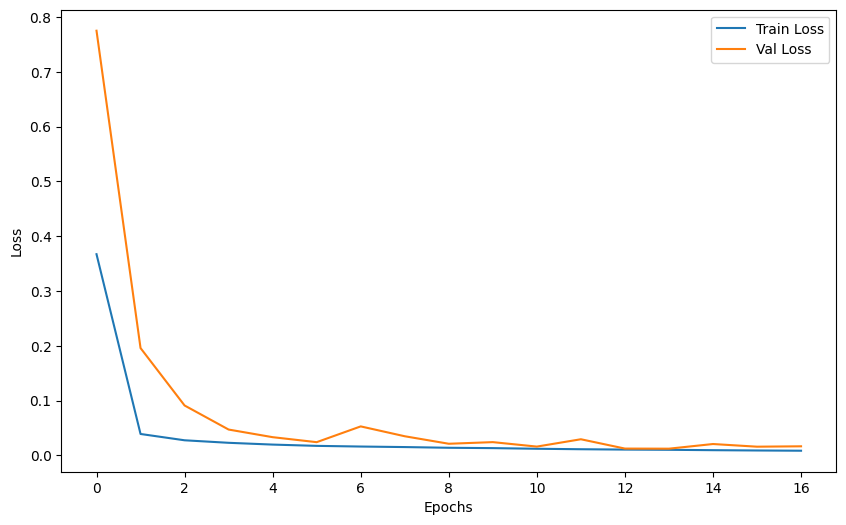

In [167]:
# training the model

num_epochs = 17
device = "cpu"
input_size = 4
hidden_size = 64
num_layers = 2
output_size = 5
learning_rate = 0.0003

model = LSTMPredictor(input_size, hidden_size, num_layers, output_size)
model.to(device)

train_losses = []
val_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
  model.train()
  epoch_train_loss = 0.0
  for input, target in train_loader:
    input - input.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    output = model(input)
    loss = criterion(output, target)

    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item()

  average_train_loss = epoch_train_loss / len(train_loader)
  train_losses.append(average_train_loss)

  model.eval()
  epoch_val_loss = 0.0
  for input, target in val_loader:

    input = input.to(device)
    target = target.to(device)

    output = model(input)

    loss = criterion(output, target)
    epoch_val_loss += loss.item()

  average_val_loss = epoch_val_loss / len(val_loader)
  val_losses.append(average_val_loss)

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")

plt.figure(figsize = (10, 6))
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


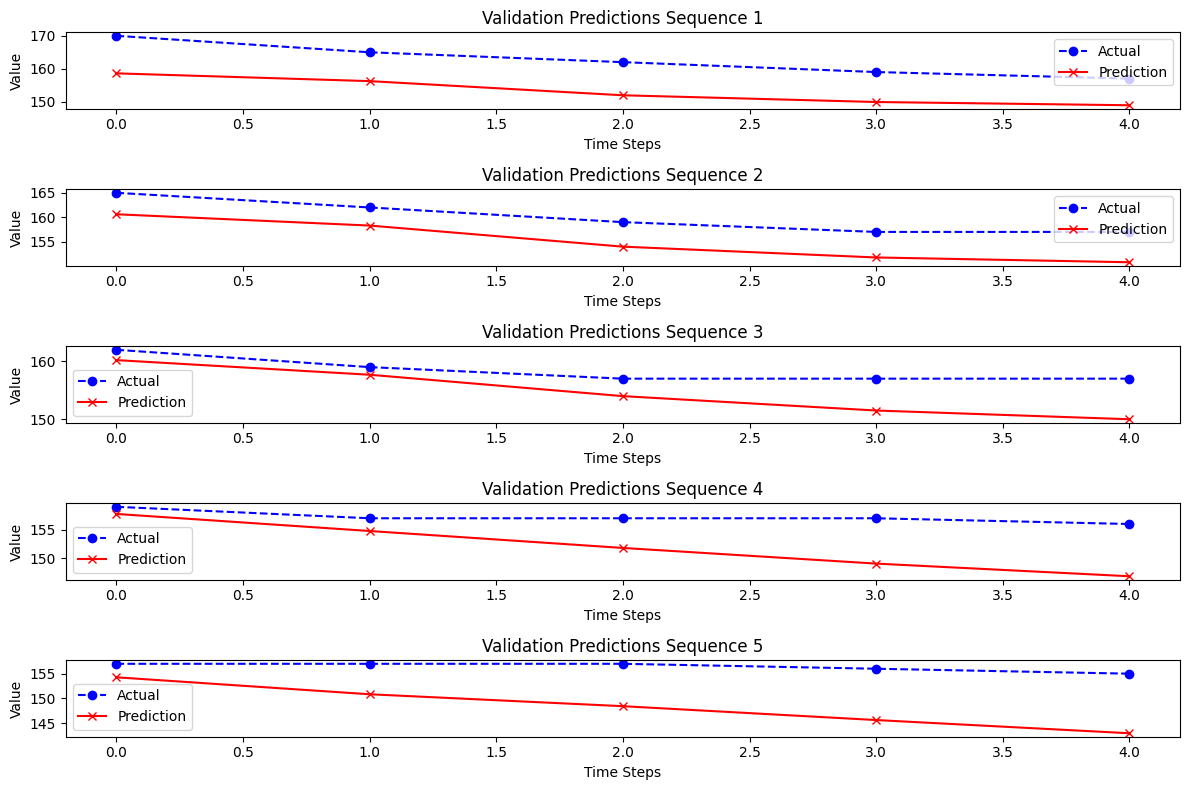

In [168]:
def make_predictions(model, data_loader, device):
    model.eval()
    history = []
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            history.append(inputs[:, :, 0])
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    history = np.concatenate(history, axis = 0)
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return history, predictions, actuals


val_history, val_predictions, val_actuals = make_predictions(model, val_loader, device)

def plot_predictions(predictions, actuals, title, num_sequences=5):
    actuals = actuals * std + mean
    predictions = predictions * std + mean

    plt.figure(figsize=(12, 8))
    for i in range(num_sequences):
        plt.subplot(num_sequences, 1, i + 1)
        plt.plot(actuals[i], label="Actual", marker='o', linestyle='--', color="blue")
        plt.plot(predictions[i], label="Prediction", marker='x', linestyle='-', color="red")
        plt.legend()
        plt.title(f"{title} Sequence {i + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Value")
    plt.tight_layout()
    plt.show()


plot_predictions(val_predictions, val_actuals, title="Validation Predictions")



Test Mean Squared Error (MSE): 13.7364
Test Mean Absolute Error (MAE): 2.5911
Test R² Score: 0.9803


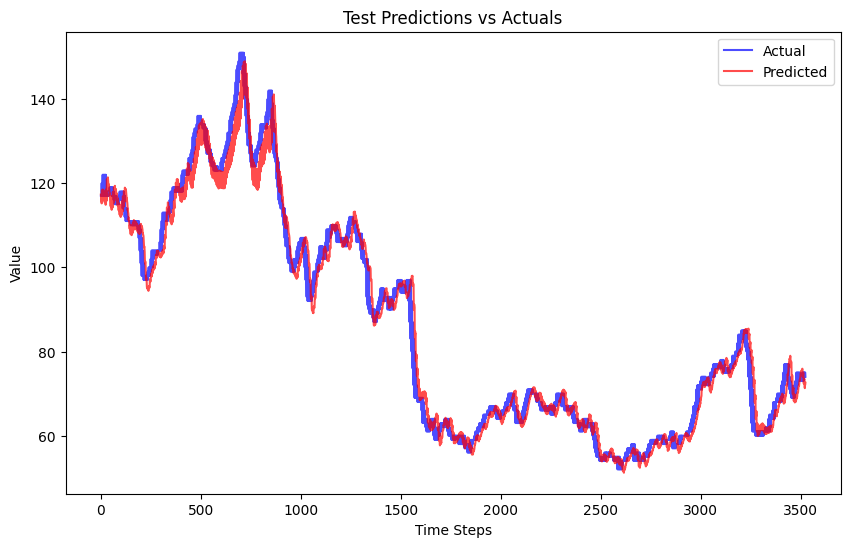

In [169]:
def evaluate_model(model, data_loader, device):

    model.eval()
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            all_predictions.append(outputs.cpu().numpy())
            all_actuals.append(targets.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    return all_predictions, all_actuals

# get predictions and denormalize prices
test_predictions, test_actuals = evaluate_model(model, test_loader, device)
test_predictions = test_predictions * std + mean
test_actuals = test_actuals * std + mean


# test metrics
mse = mean_squared_error(test_actuals, test_predictions)
mae = mean_absolute_error(test_actuals, test_predictions)
r2 = r2_score(test_actuals, test_predictions)

print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(test_actuals.flatten(), label="Actual", color="blue", alpha=0.7)
plt.plot(test_predictions.flatten(), label="Predicted", color="red", alpha=0.7)
plt.title("Test Predictions vs Actuals")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

